In [1]:
from generate_configurations import read_configurations
import numpy as np
import matplotlib.pyplot as plt
from corr_funcs import *
from ising import corr_analytical
from scipy.stats import sem
from matplotlib.ticker import FormatStrFormatter


In [2]:
sizes = [100, 1000]
betas = [0.5, 1, 2]
corr_functions = [corr_1, corr_2, corr_3, corr_4, corr_5, corr_6]
nrows = len(betas)
ncols = len(sizes)

In [3]:
loaded_data = {}
for size in sizes:
    for beta in betas:
        file_name = f'data/{size}_{beta}.npz'
        configurations, _, _, params = read_configurations(file_name)
        loaded_data[(size, beta)] = (configurations, params)

In [4]:
equations = {
    'corr_1': r'$\hat{C}_1(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} \right)$',
    'corr_2': r'$\hat{C}_2(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right) \left( \frac{1}{R} \sum_{k=1}^{R} \sigma_{i+r} \right) \right)$',
    'corr_3': r'$\hat{C}_3(r) = \frac{\hat{C}_2(r)}{\hat{C}_2(0)}$',
    'corr_4': r'$\hat{C}_4(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right) \left( 1 - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right)$',
    'corr_5': r'$\hat{C}_5(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{R} \sum_{k=1}^{R} \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right)$',
    'corr_6': r'$\hat{C}_6(r) = \frac{\hat{C}_5(r)}{\hat{C}_5(0)}$',
}

In [5]:
r_values = [np.arange(0, 10, 1), np.arange(0, 20, 1), np.arange(0, 50, 1)]

In [6]:
corrs = np.zeros((len(corr_functions), len(sizes), len(betas), len(r_values[-1])))
for k, corr_function in enumerate(corr_functions):
    for i, size in enumerate(sizes):
        for j, beta in enumerate(betas):
            file_name = f'data/{size}_{beta}.npz'
            configurations, params = loaded_data[(size, beta)]
            cr = corr_function_parallel(configurations, np.arange(0, 50), corr_function)
            corrs[k, i, j, :] = cr

In [7]:
corrs_an = np.zeros((len(sizes), len(betas), len(r_values[-1])))
for i, size in enumerate(sizes):
    for j, beta in enumerate(betas):
        rs = r_values[-1]
        file_name = f'data/{size}_{beta}.npz'
        configurations, params = loaded_data[(size, beta)]
        cr = np.array([corr_analytical(params['beta'], params['J'], params['size'], r) for r in rs])
        corrs_an[i, j, :] = cr

In [8]:
errors = np.zeros((len(sizes), len(betas), len(corr_functions), len(r_values[-1])))
for i in range(len(sizes)):
    for j in range(len(betas)):
        cr = np.array([corrs[k][i][j] for k in range(len(corr_functions))])
        errors[i, j,: ,:] = sem(cr, axis=0)

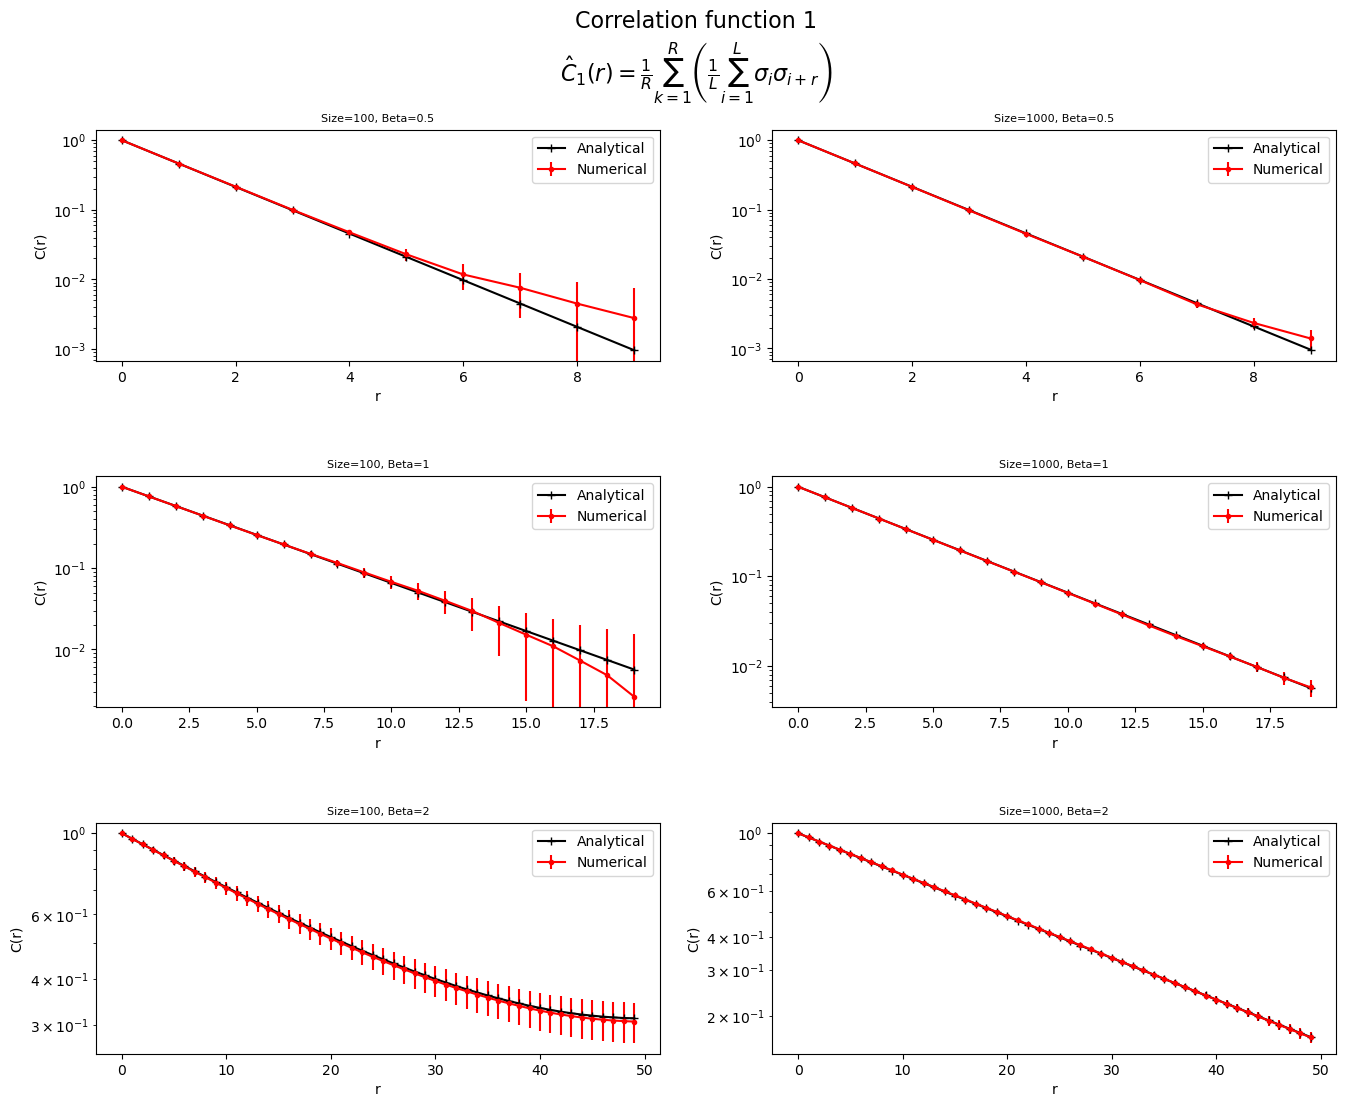

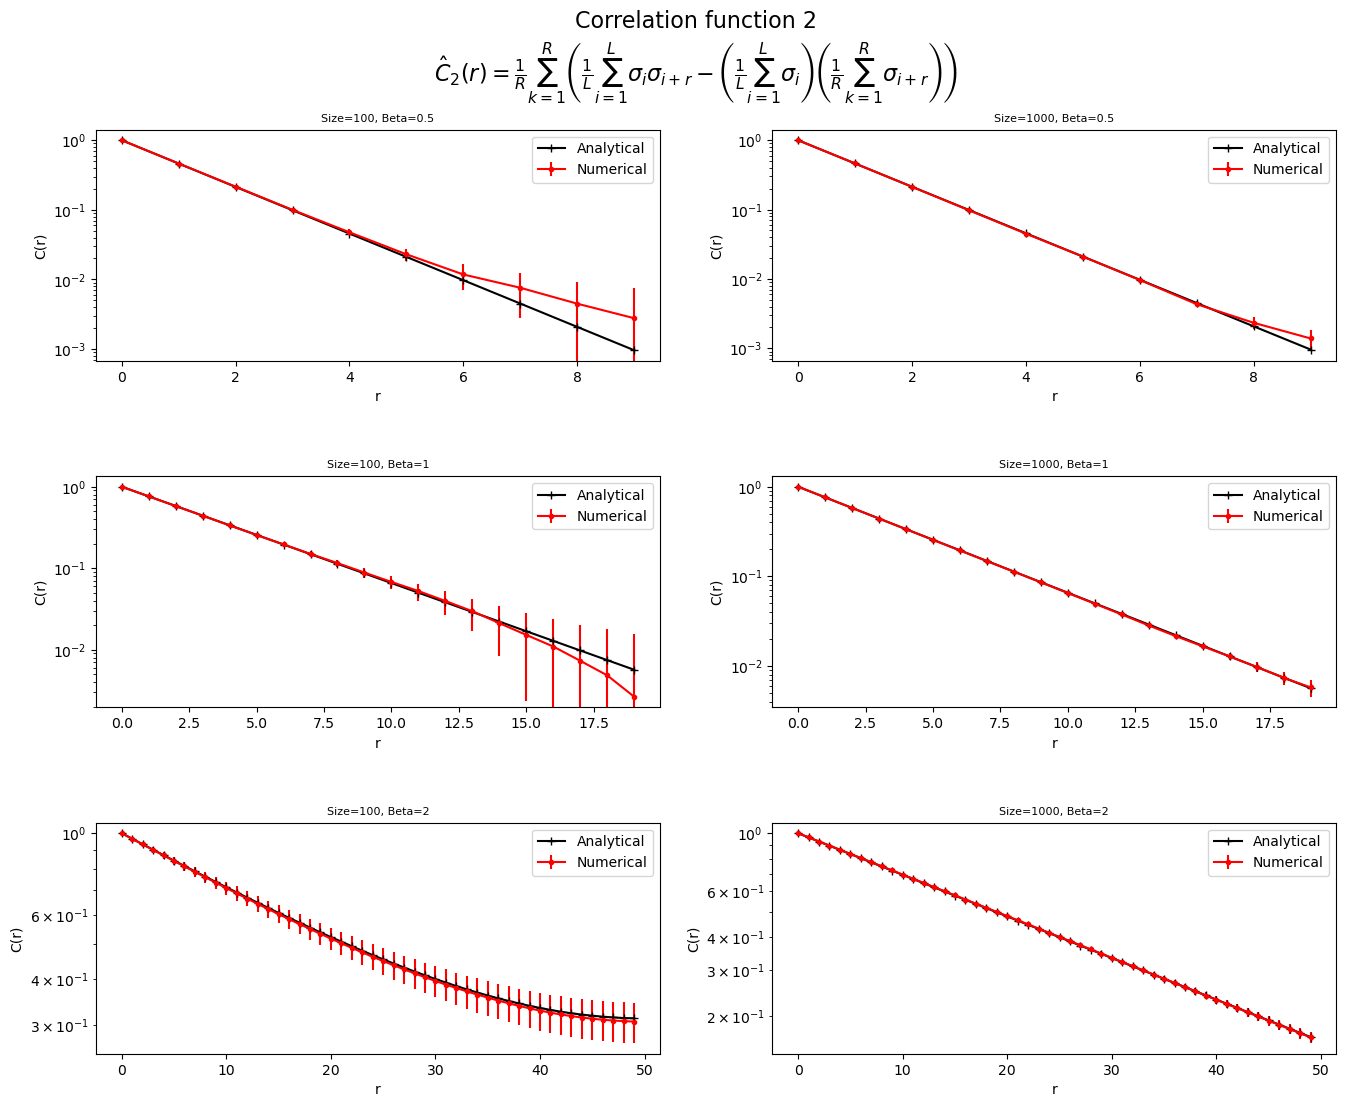

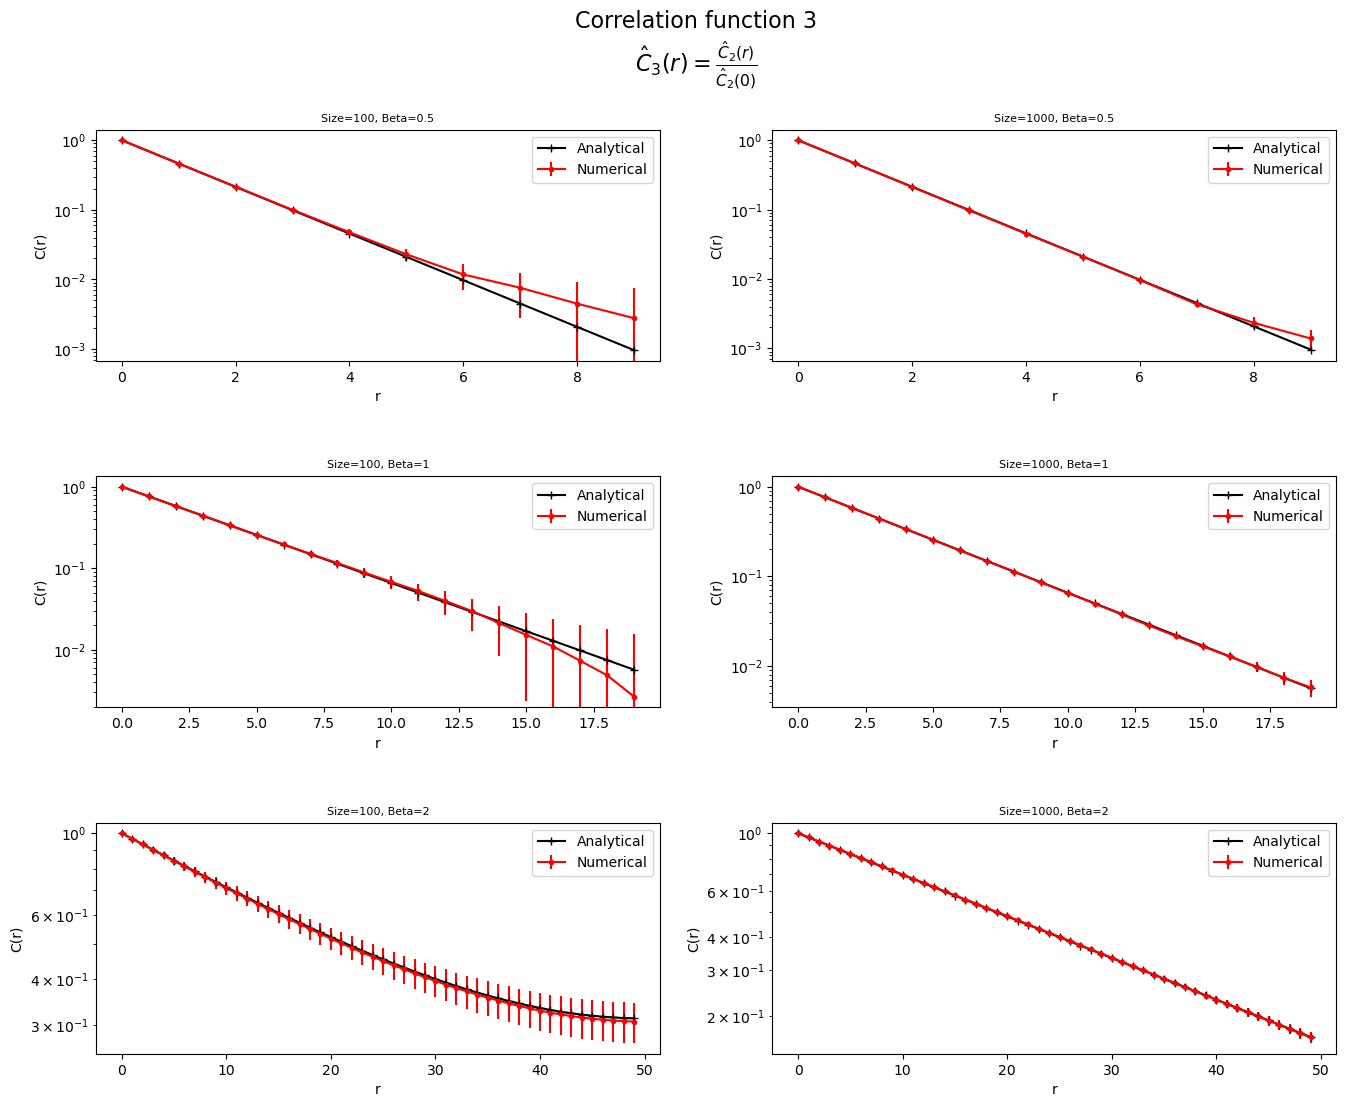

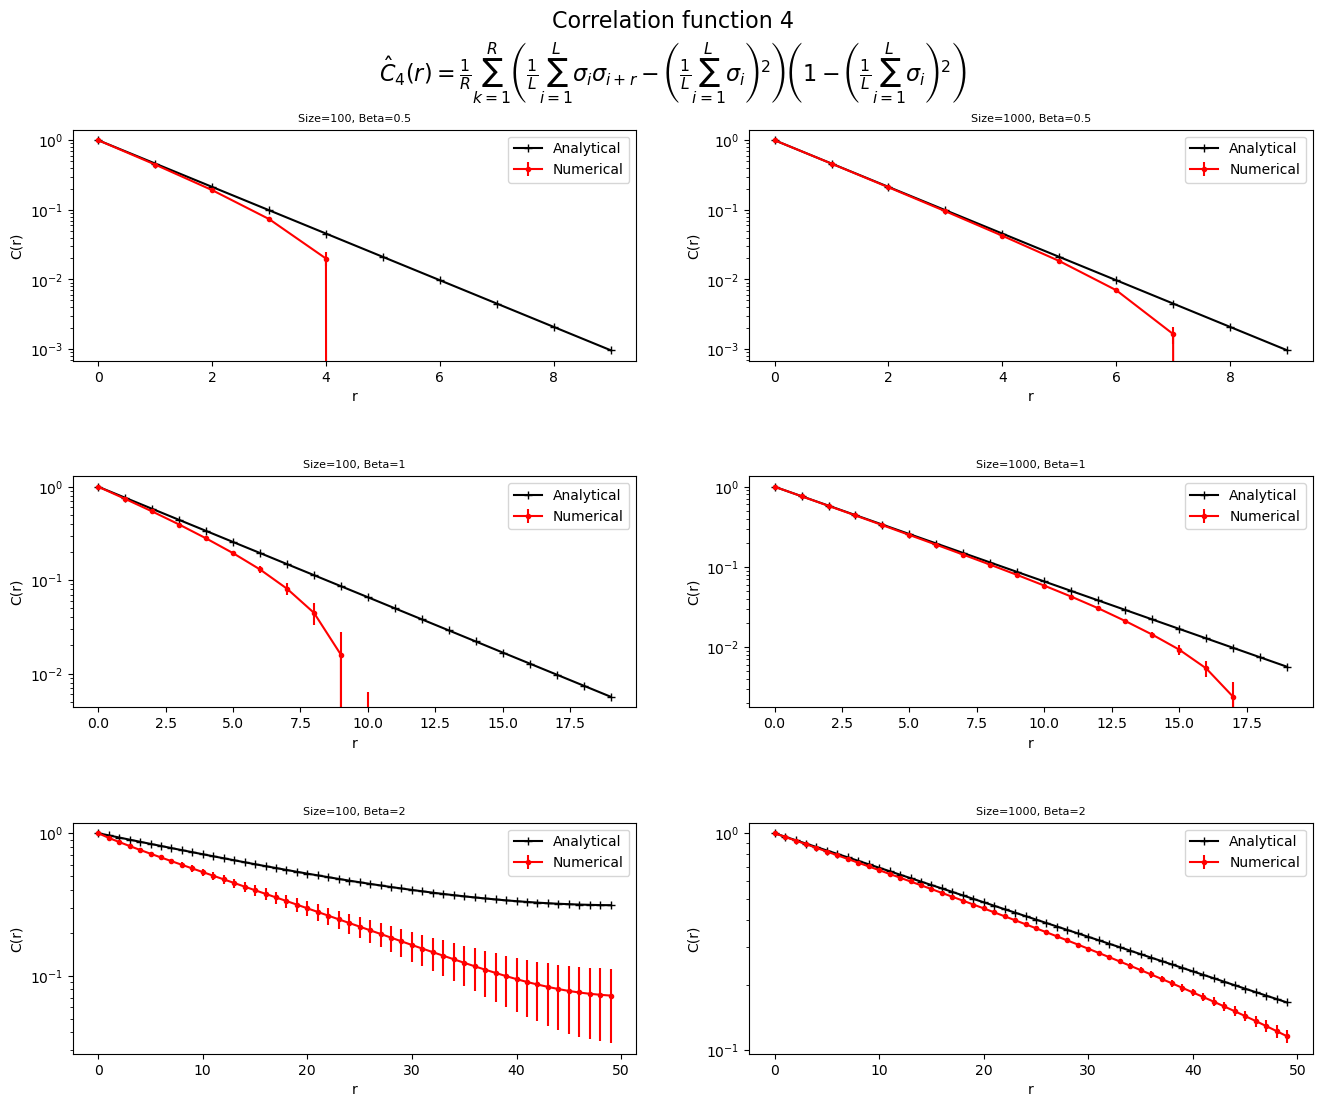

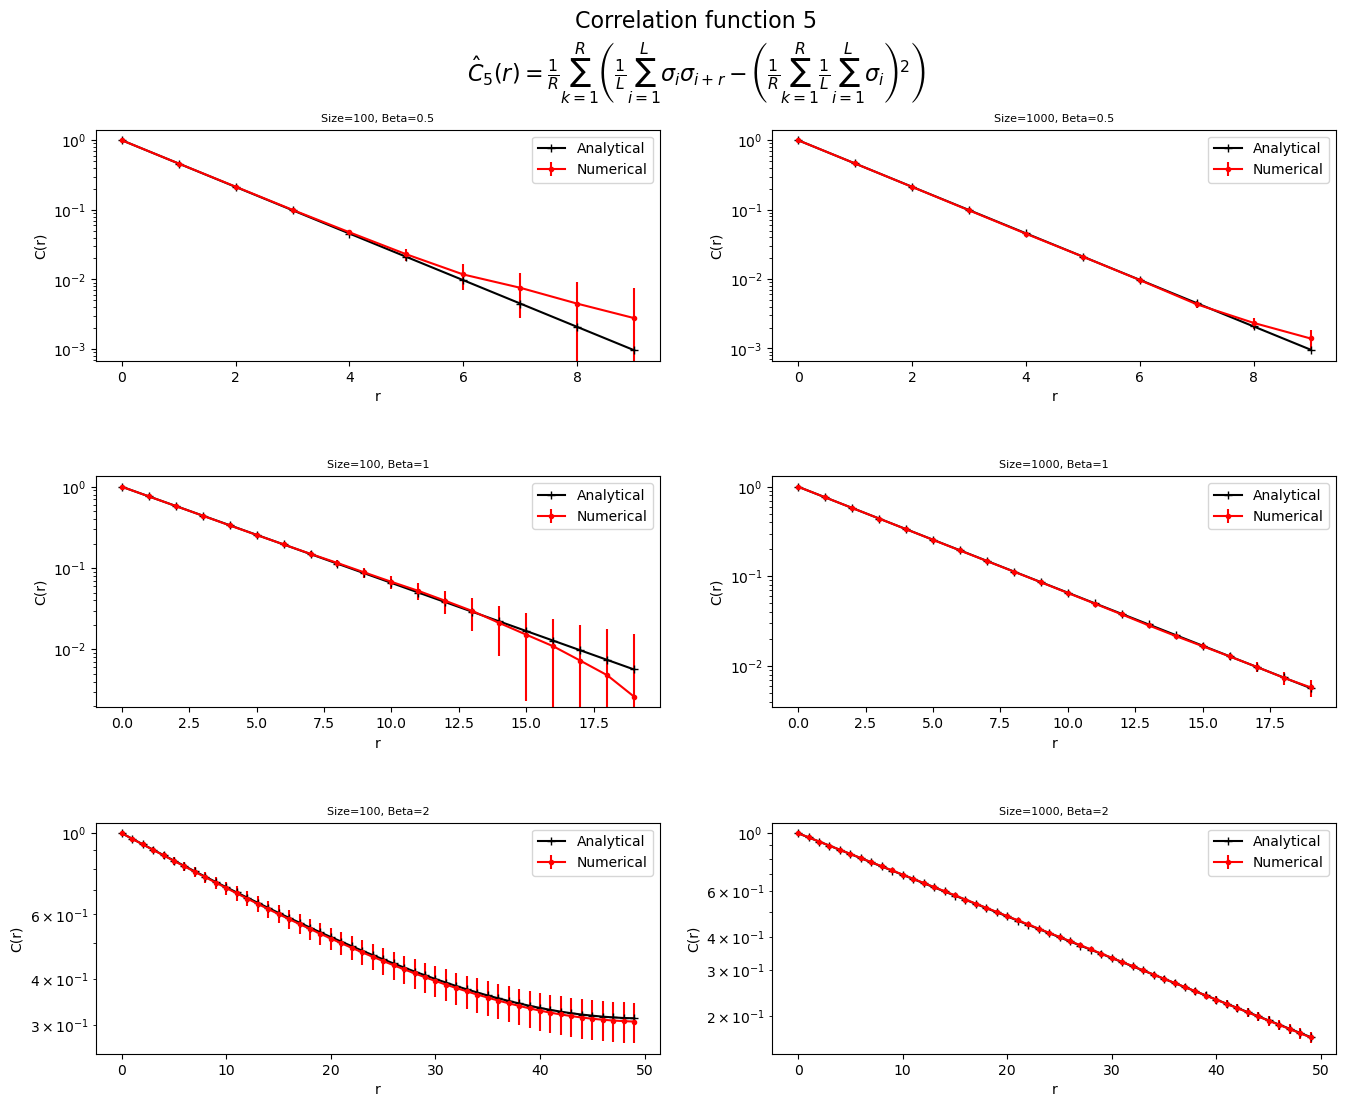

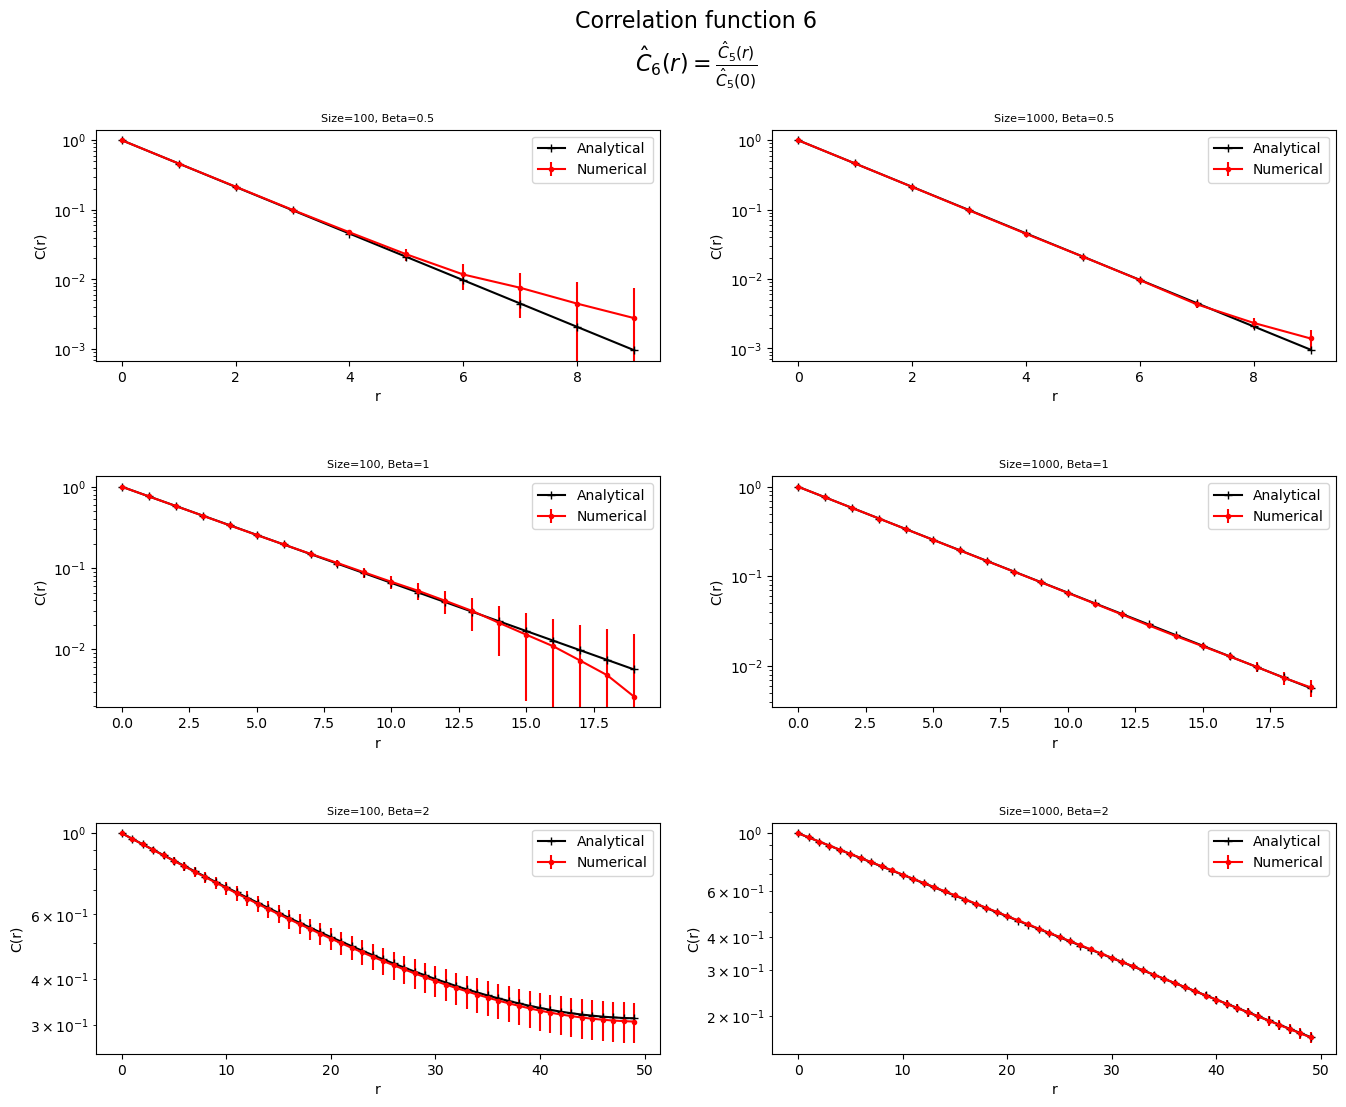

In [9]:
for k, corr_function in enumerate(corr_functions):
    equation = equations.get(corr_function.__name__, 'Equation not defined')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 4), gridspec_kw={'hspace': 0.5})
    fig.suptitle(f'Correlation function {k+1}\n{equation}', fontsize=16)
    for i, size in enumerate(sizes):
        for j, beta in enumerate(betas):
            rs = r_values[j]
            cr = corrs[k][i][j]
            ax = axes[j, i]
            yerr = errors[i][j][k][:len(rs)]
            
            ax.errorbar(rs, cr[:len(rs)], yerr=yerr, label='Numerical', marker='.', color='red')
            ax.plot(rs, corrs_an[i][j][:len(rs)], label='Analytical', marker='+', color='black')
            
            ax.set_title(f'Size={size}, Beta={beta}', fontsize=8)
            ax.set_xlabel('r')
            ax.set_ylabel('C(r)')
            ax.set_yscale('log')
            ax.legend()
    #fig.savefig(f'plots/{corr_function.__name__}.pdf', bbox_inches='tight')

/var/folders/rw/vv5ykjx52pbgmf58r98xgwn80000gn/T/ipykernel_16071/1638348436.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

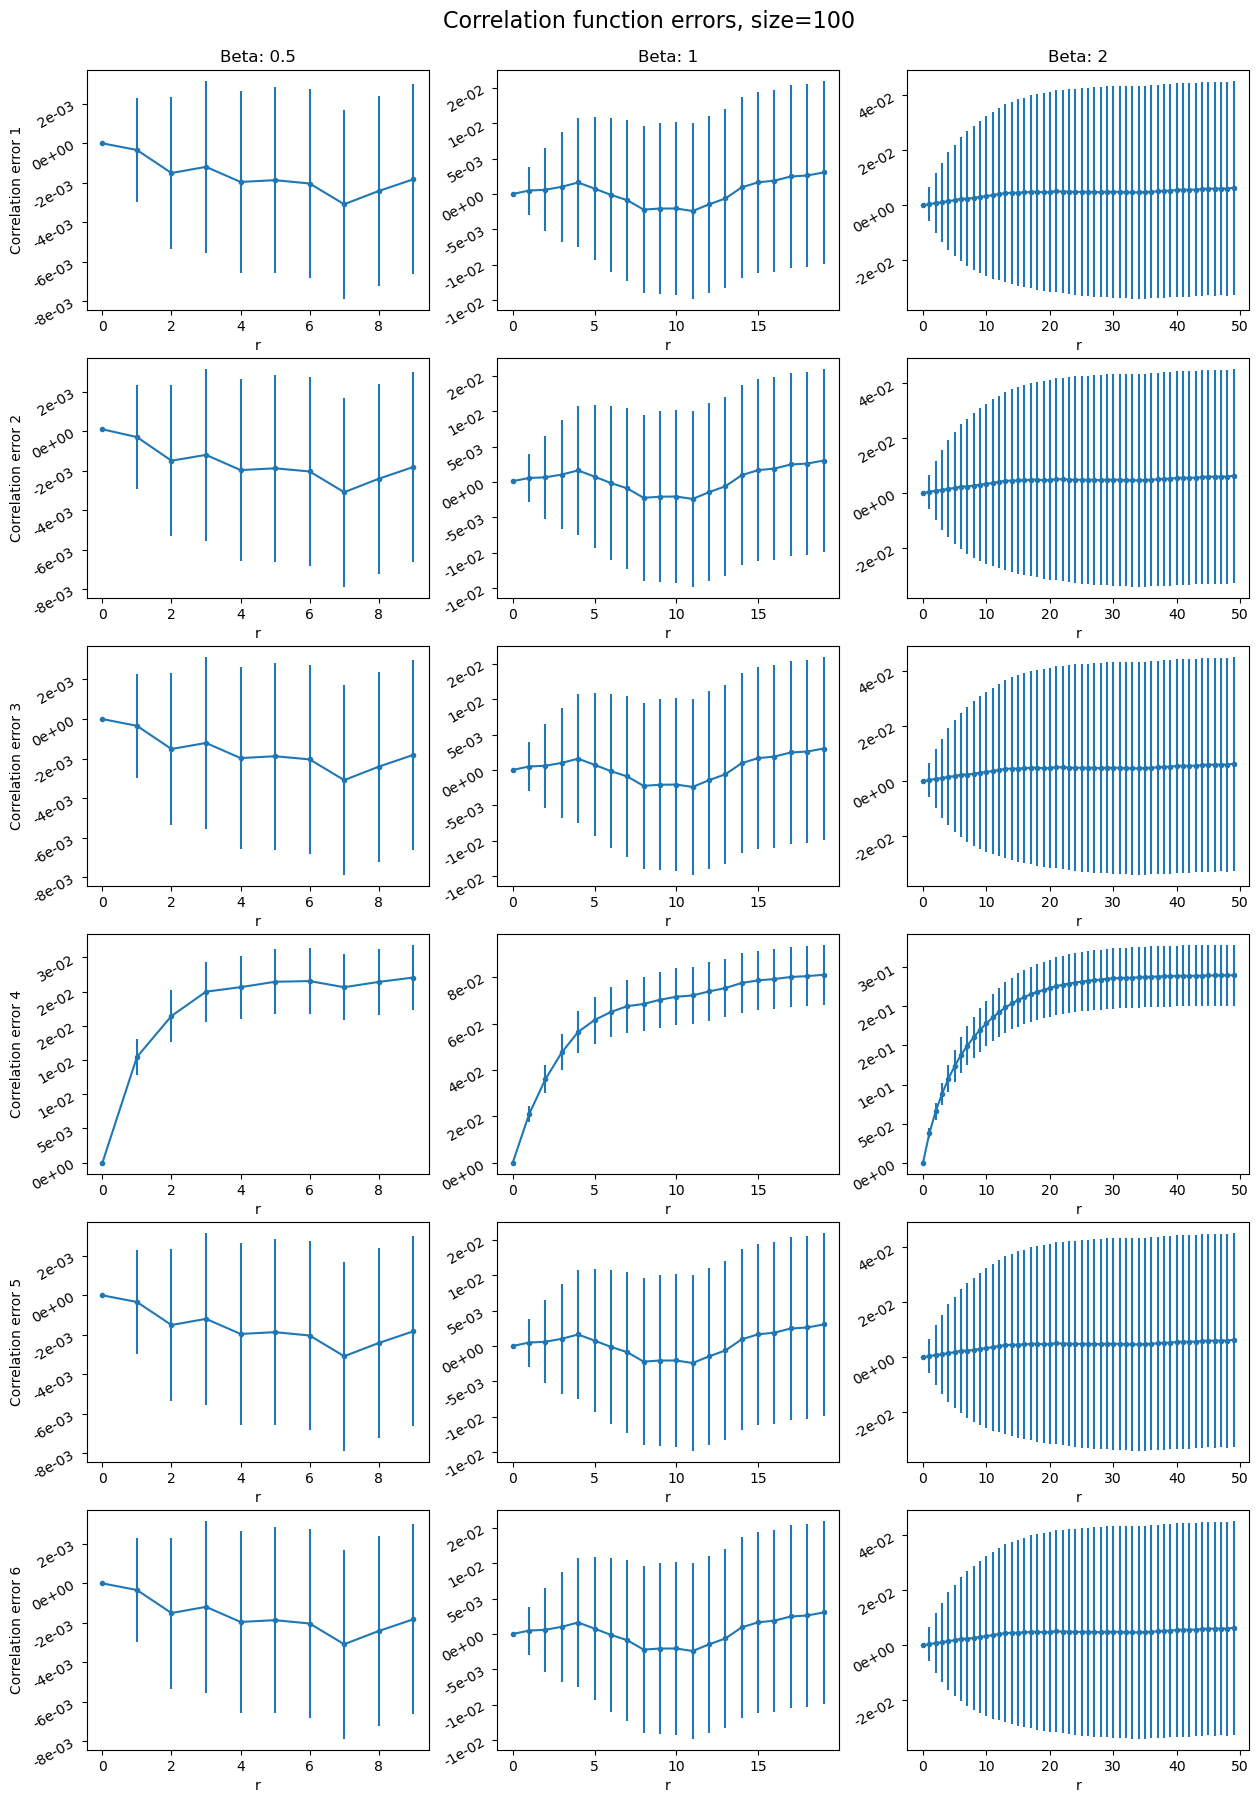

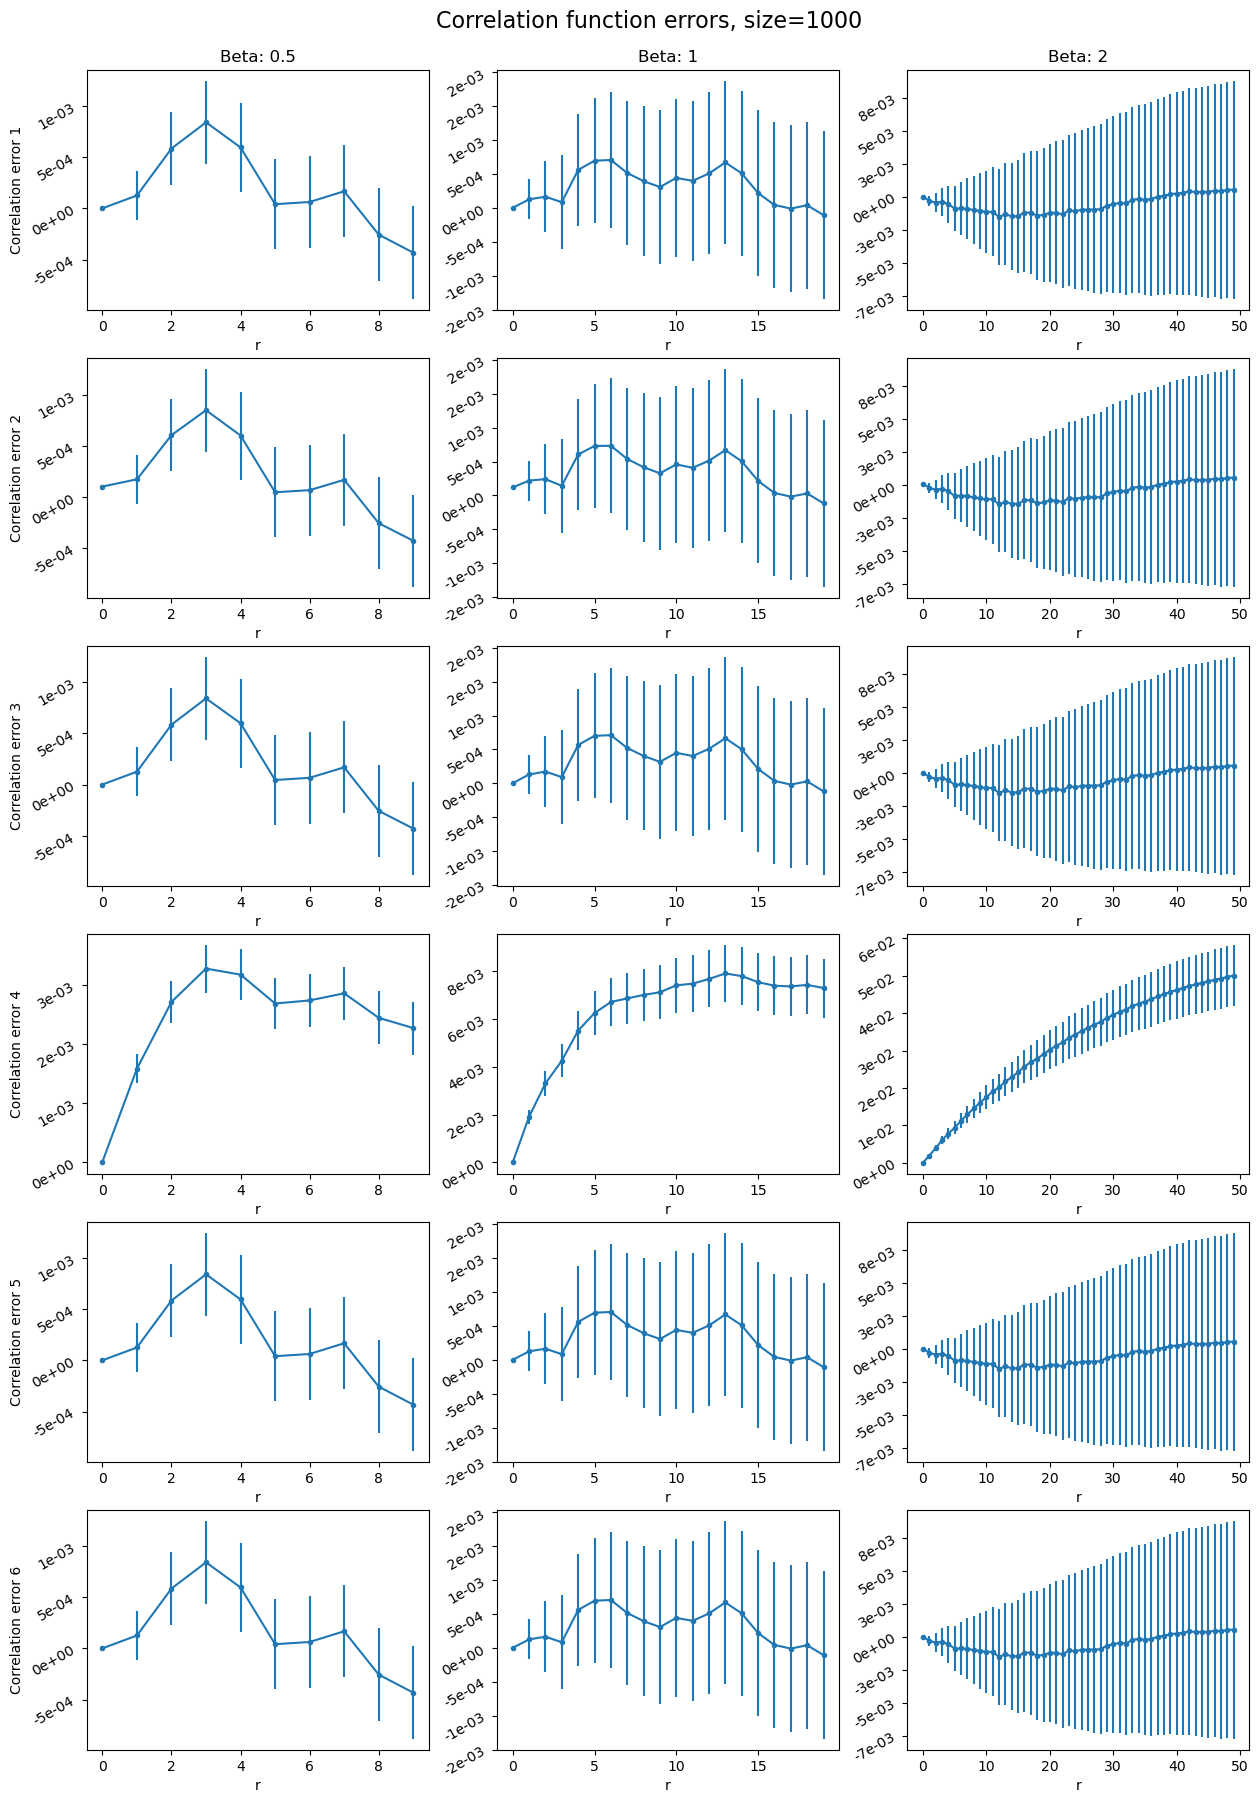

In [10]:
plt.tight_layout()
for i, size in enumerate(sizes):
    fig, axes = plt.subplots(nrows=len(corrs), ncols=len(betas), figsize=(15, 20))
    fig.suptitle(f'Correlation function errors, size={size}', fontsize=16)
    for j, beta in enumerate(betas):
        axes[0, j].set_title(f'Beta: {beta}')
    
    for j, beta in enumerate(betas):
        for k, corr_function in enumerate(corr_functions):
            ax = axes[k, j]
            rs = r_values[j]
            cr = corrs[k][i][j][:len(rs)]
            cr_an = corrs_an[i][j][:len(rs)]
            err = errors[i][j][k][:len(rs)]
            
            ax.errorbar(rs, cr_an - cr, yerr=err,
                        label=f'{corr_function.__name__}, beta:{beta}', marker='.')
            
            ax.set_xlabel('r')
            ax.tick_params(axis = 'y', rotation = 30)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))



    for k, corr_function in enumerate(corr_functions):
        axes[k, 0].set_ylabel(f'Correlation error {k+1}')
    fig.subplots_adjust(top=0.95)
    fig.show()



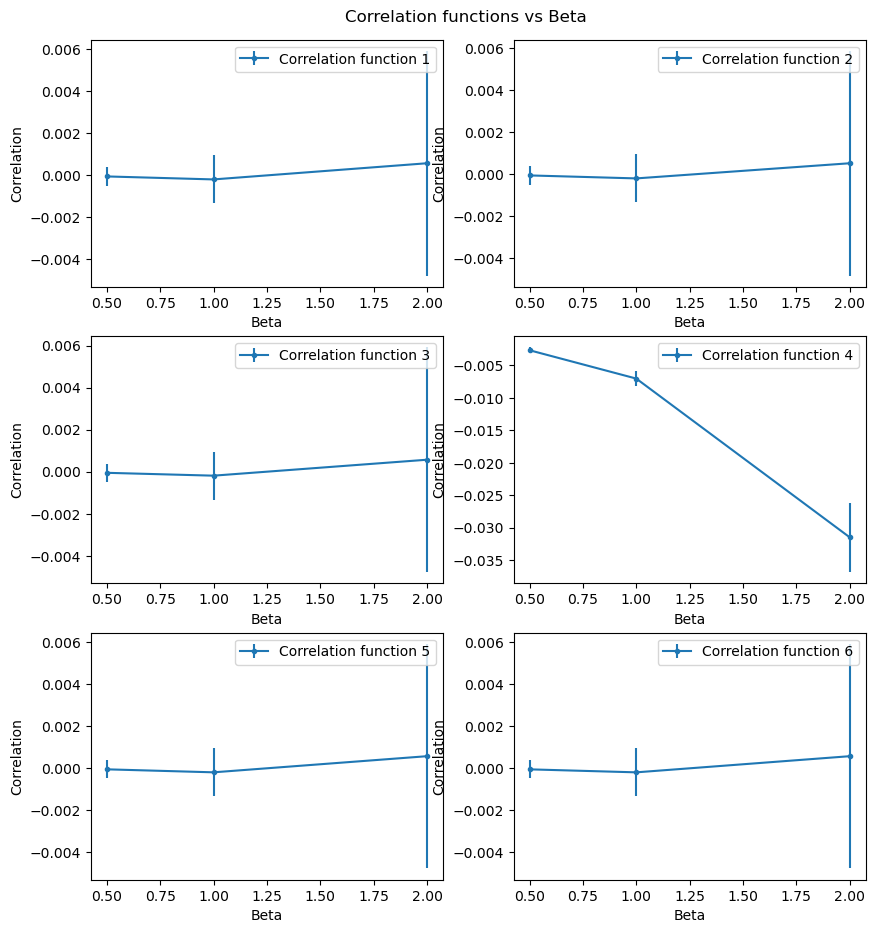

In [23]:
# Plot of correlation functions vs beta
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Correlation functions vs Beta')
fig.subplots_adjust(top=0.95)
for k, corr_function in enumerate(corr_functions):
    cr = (corrs[k]-corrs_an)[1].mean(axis=-1)
    cr_err = errors[1, :, k].mean(axis=-1)
    ax = axes[k // 2, k % 2]
    ax.errorbar(betas, cr, yerr= cr_err,marker='.', label=f'Correlation function {k+1}')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Correlation')
    ax.legend()
plt.show()


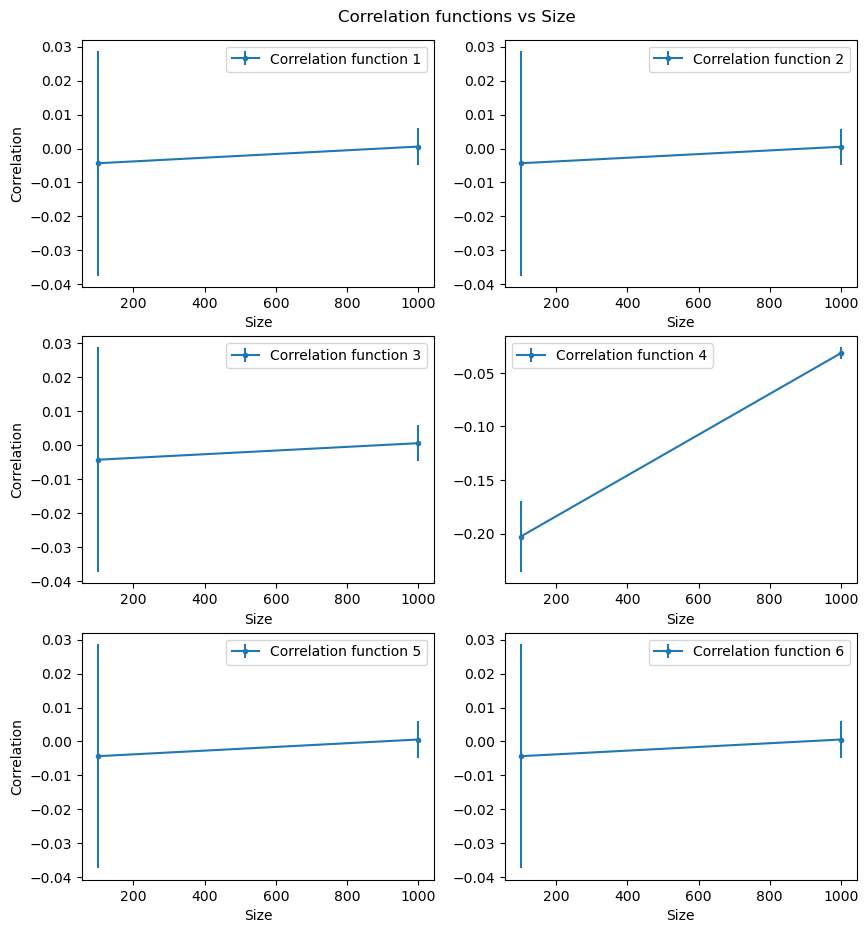

In [24]:
# Plot of correlation functions vs size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Correlation functions vs Size')
fig.subplots_adjust(top=0.95)
for k, corr_function in enumerate(corr_functions):
    cr = (corrs[k]-corrs_an)[:,-1].mean(axis=-1)
    cr_err = errors[:, -1, k].mean(axis=-1)
    ax = axes[k // 2, k % 2]
    ax.errorbar(sizes, cr, yerr=cr_err,marker='.', label=f'Correlation function {k+1}')
    ax.set_xlabel('Size')
    if k%2 == 0:
        ax.set_ylabel('Correlation')
    ax.legend()
plt.show()